In [51]:
"""
Author: Vedika Srivastava
"""

import tensorflow as tf
import numpy as np
import cv2
import os
import glob

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/Shareddrives/Project IVC")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
# Load a pre-trained InceptionV3 model
inception_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', pooling='avg')

In [53]:
# Define a function to preprocess the images to be compatible with the InceptionV3 model
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    #img = cv2.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

# Define a function to calculate the mean and covariance of the InceptionV3 features for a given set of images
def calculate_activation_statistics(images, model):
    features = model.predict(images)
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

# Define a function to calculate the FID score between two sets of images using their InceptionV3 features
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    # diff = mu1 - mu2
    # # Product might be almost singular
    # covmean, _ = tf.linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    # if not np.isfinite(covmean).all():
    #     offset = np.eye(sigma1.shape[0]) * eps
    #     covmean = tf.linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    # # Numerical error might give slight imaginary component
    # if np.iscomplexobj(covmean):
    #     if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
    #         m = np.max(np.abs(covmean.imag))
    #         raise ValueError('Imaginary component {}'.format(m))
    #     covmean = covmean.real
    # tr_covmean = tf.linalg.trace(covmean)
    # return diff.dot(diff) + tf.trace(sigma1) + tf.trace(sigma2) - 2 * tr_covmean


    # """Numpy implementation of the Frechet Distance."""
    # # Calculate the matrix square root of the covariance matrices
    # sigma1 = tf.convert_to_tensor(sigma1)
    # sigma2 = tf.convert_to_tensor(sigma2)
    # covmean, _ = tf.linalg.sqrtm(sigma1 @ sigma2)

    # # Check for numerical issues
    # if not np.isfinite(covmean).all():
    #     msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
    #     print(msg)
    #     offset = np.eye(sigma1.shape[0]) * eps
    #     covmean = tf.linalg.sqrtm((sigma1 + offset) @ (sigma2 + offset))

    # # Calculate the squared difference between the means
    # diff = mu1 - mu2
    # diff = diff @ diff

    # # Calculate the trace of the product of the covariance matrices
    # tr_covmean = tf.linalg.trace(covmean)

    # # Calculate the final FID score
    # return diff + sigma1.trace() + sigma2.trace() - 2 * tr_covmean

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, 'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, 'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean = tf.linalg.sqrtm(tf.linalg.matmul(sigma1, sigma2))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    # Calculate score
    tr_covmean = tf.linalg.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)

In [54]:
# Define content, style, and stylized image paths
content_path = "./image_files/content/building.jpg"
style_path = "./image_files/style/1.jpg"
stylized_path = "./DFR/content_building_style_1.jpg"

# Preprocess the images
content_img = preprocess_image(content_path)
style_img = preprocess_image(style_path)
stylized_img = preprocess_image(stylized_path)

# Calculate the mean and covariance of the InceptionV3 features for the content, style, and stylized images
content_mu, content_sigma = calculate_activation_statistics(content_img[np.newaxis], inception_model)
style_mu, style_sigma = calculate_activation_statistics(style_img[np.newaxis], inception_model)
stylized_mu, stylized_sigma = calculate_activation_statistics(stylized_img[np.newaxis], inception_model)

# Calculate the FID score between the content and stylized images
fid_score_content_stylized = calculate_frechet_distance(content_mu, content_sigma, stylized_mu, stylized_sigma)
fid_score_style_stylized = calculate_frechet_distance(style_mu, style_sigma, stylized_mu, stylized_sigma)
print("FID score between content and stylized images: {}".format(fid_score_content_stylized))
print("FID score between style and stylized images: {}".format(fid_score_style_stylized))

1/1 [==============================] - 0s 342ms/step
FID score between content and stylized images: 656.8667227931478
FID score between style and stylized images: 838.8469053534873


> **Interpretation for one FID score for understanding**
>
> The FID (Fréchet Inception Distance) scores are a way to measure the similarity between two sets of images based on their feature representations. In this case, we have calculated two FID scores:
>
> 1. FID score between content and stylized images: 656.8667227931478
> 2. FID score between style and stylized images: 838.8469053534873
>
> The lower the FID score, the more similar the two sets of images are. In other words, a low FID score indicates that the stylized images are more similar to the original images in terms of their feature representations. Conversely, a high FID score suggests that the stylized images are less similar to the original images.
>
> In this case, the FID scores indicate that the stylized images are not very similar to the original images. This could be due to various factors such as the choice of style transfer algorithm, the quality of the images, or the specific characteristics of the images used. It is important to note that FID scores should be interpreted in the context of the specific task and dataset being used, and should not be taken as absolute measures of similarity.

Looping over all outputs - DFR

In [67]:
fid_score_content_stylized_dfr = []
fid_score_style_stylized_dfr = []

try:
    for i, content_path in enumerate(sorted(glob.glob("./image_files/content/*.jpg"))):
        first_index = i * 5
        last_index = first_index + 5
        for style_path, stylized_path in zip(sorted(glob.glob("./image_files/style/*.jpg")), sorted(glob.glob("./DFR/*.jpg"))[first_index:last_index]): #change folder name here to check for your outputs
          # Preprocess the images
          content_img = preprocess_image(content_path)
          style_img = preprocess_image(style_path)
          stylized_img = preprocess_image(stylized_path)

          # Calculate the mean and covariance of the InceptionV3 features for the content, style, and stylized images
          content_mu, content_sigma = calculate_activation_statistics(content_img[np.newaxis], inception_model)
          style_mu, style_sigma = calculate_activation_statistics(style_img[np.newaxis], inception_model)
          stylized_mu, stylized_sigma = calculate_activation_statistics(stylized_img[np.newaxis], inception_model)

          # Calculate the FID score between the content and stylized images
          fid_score_content_stylized = calculate_frechet_distance(content_mu, content_sigma, stylized_mu, stylized_sigma)
          fid_score_content_stylized_dfr.append(fid_score_content_stylized.numpy())

          fid_score_style_stylized = calculate_frechet_distance(style_mu, style_sigma, stylized_mu, stylized_sigma)
          fid_score_style_stylized_dfr.append(fid_score_style_stylized.numpy())

          print(content_path)
          print(style_path)
          print(stylized_path)
          print("FID score between content and stylized images: {}".format(fid_score_content_stylized))
          print("FID score between style and stylized images: {}".format(fid_score_style_stylized))
          print("\n")

except:
    print("invalid path/flie can't be opened")

1/1 [==============================] - 0s 185ms/step
./image_files/content/building.jpg
./image_files/style/1.jpg
./DFR/content_building_style_1.jpg
FID score between content and stylized images: 656.8667227931478
FID score between style and stylized images: 838.8469053534873


1/1 [==============================] - 0s 228ms/step
./image_files/content/building.jpg
./image_files/style/2.jpg
./DFR/content_building_style_2.jpg
FID score between content and stylized images: 320.8417182580355
FID score between style and stylized images: 626.0389415445854


1/1 [==============================] - 1s 563ms/step
./image_files/content/building.jpg
./image_files/style/3.jpg
./DFR/content_building_style_3.jpg
FID score between content and stylized images: 266.0484972568794
FID score between style and stylized images: 535.71828853246


1/1 [==============================] - 0s 357ms/step
./image_files/content/building.jpg
./image_files/style/4.jpg
./DFR/content_building_style_4.jpg
FID score betwee

Looping over all outputs - artistic_256

In [77]:
fid_score_content_stylized_art = []
fid_score_style_stylized_art = []

try:
    for i, content_path in enumerate(sorted(glob.glob("./image_files/content/*.jpg"))):
        first_index = i * 5
        last_index = first_index + 5
        for style_path, stylized_path in zip(sorted(glob.glob("./image_files/style/*.jpg")), sorted(glob.glob("./artistic_256/*.jpg"))[first_index:last_index]): #change folder name here to check for your outputs
          # Preprocess the images
          content_img = preprocess_image(content_path)
          style_img = preprocess_image(style_path)
          stylized_img = preprocess_image(stylized_path)

          # Calculate the mean and covariance of the InceptionV3 features for the content, style, and stylized images
          content_mu, content_sigma = calculate_activation_statistics(content_img[np.newaxis], inception_model)
          style_mu, style_sigma = calculate_activation_statistics(style_img[np.newaxis], inception_model)
          stylized_mu, stylized_sigma = calculate_activation_statistics(stylized_img[np.newaxis], inception_model)

          # Calculate the FID score between the content and stylized images
          fid_score_content_stylized = calculate_frechet_distance(content_mu, content_sigma, stylized_mu, stylized_sigma)
          fid_score_content_stylized_art.append(fid_score_content_stylized.numpy())

          fid_score_style_stylized = calculate_frechet_distance(style_mu, style_sigma, stylized_mu, stylized_sigma)
          fid_score_style_stylized_art.append(fid_score_style_stylized.numpy())
          
          print(content_path)
          print(style_path)
          print(stylized_path)
          print("FID score between content and stylized images: {}".format(fid_score_content_stylized))
          print("FID score between style and stylized images: {}".format(fid_score_style_stylized))
          print("\n")

except:
    print("invalid path/flie can't be opened")

1/1 [==============================] - 0s 196ms/step
./image_files/content/building.jpg
./image_files/style/1.jpg
./artistic_256/content_building_style_1.jpg
FID score between content and stylized images: 238.04115416192272
FID score between style and stylized images: 832.1540762062314


1/1 [==============================] - 0s 358ms/step
./image_files/content/building.jpg
./image_files/style/2.jpg
./artistic_256/content_building_style_2.jpg
FID score between content and stylized images: 222.55379885493898
FID score between style and stylized images: 614.1031682145477


1/1 [==============================] - 0s 346ms/step
./image_files/content/building.jpg
./image_files/style/3.jpg
./artistic_256/content_building_style_3.jpg
FID score between content and stylized images: 151.56538528629127
FID score between style and stylized images: 529.0346483952987


1/1 [==============================] - 0s 198ms/step
./image_files/content/building.jpg
./image_files/style/4.jpg
./artistic_256/cont

Looping over all outputs - fast_style_256

In [69]:
fid_score_content_stylized_fst = []
fid_score_style_stylized_fst = []

try:
    for i, content_path in enumerate(sorted(glob.glob("./image_files/content/*.jpg"))):
        first_index = i * 5
        last_index = first_index + 5
        for style_path, stylized_path in zip(sorted(glob.glob("./image_files/style/*.jpg")), sorted(glob.glob("./fast_style_256/*.jpg"))[first_index:last_index]): #change folder name here to check for your outputs
          # Preprocess the images
          content_img = preprocess_image(content_path)
          style_img = preprocess_image(style_path)
          stylized_img = preprocess_image(stylized_path)

          # Calculate the mean and covariance of the InceptionV3 features for the content, style, and stylized images
          content_mu, content_sigma = calculate_activation_statistics(content_img[np.newaxis], inception_model)
          style_mu, style_sigma = calculate_activation_statistics(style_img[np.newaxis], inception_model)
          stylized_mu, stylized_sigma = calculate_activation_statistics(stylized_img[np.newaxis], inception_model)

          # Calculate the FID score between the content and stylized images
          fid_score_content_stylized = calculate_frechet_distance(content_mu, content_sigma, stylized_mu, stylized_sigma)
          fid_score_content_stylized_fst.append(fid_score_content_stylized.numpy())

          fid_score_style_stylized = calculate_frechet_distance(style_mu, style_sigma, stylized_mu, stylized_sigma)
          fid_score_style_stylized_fst.append(fid_score_style_stylized.numpy())
          
          print(content_path)
          print(style_path)
          print(stylized_path)
          print("FID score between content and stylized images: {}".format(fid_score_content_stylized))
          print("FID score between style and stylized images: {}".format(fid_score_style_stylized))
          print("\n")

except:
    print("invalid path/flie can't be opened")

1/1 [==============================] - 0s 182ms/step
./image_files/content/building.jpg
./image_files/style/1.jpg
./fast_style_256/content_building_style_1.jpg
FID score between content and stylized images: 780.8666087960293
FID score between style and stylized images: 512.7287459017125


1/1 [==============================] - 0s 214ms/step
./image_files/content/building.jpg
./image_files/style/2.jpg
./fast_style_256/content_building_style_2.jpg
FID score between content and stylized images: 353.7280839582364
FID score between style and stylized images: 473.02472771809227


1/1 [==============================] - 0s 184ms/step
./image_files/content/building.jpg
./image_files/style/3.jpg
./fast_style_256/content_building_style_3.jpg
FID score between content and stylized images: 690.1667552517209
FID score between style and stylized images: 683.5006260359118


1/1 [==============================] - 0s 185ms/step
./image_files/content/building.jpg
./image_files/style/4.jpg
./fast_style_25

Looping over all outputs - neural_style_transfer

In [70]:
fid_score_content_stylized_nst = []
fid_score_style_stylized_nst = []

try:
    for i, content_path in enumerate(sorted(glob.glob("./image_files/content/*.jpg"))):
        first_index = i * 5
        last_index = first_index + 5
        for style_path, stylized_path in zip(sorted(glob.glob("./image_files/style/*.jpg")), sorted(glob.glob("./neural_style_transfer/*.jpg"))[first_index:last_index]): #change folder name here to check for your outputs
          # Preprocess the images
          content_img = preprocess_image(content_path)
          style_img = preprocess_image(style_path)
          stylized_img = preprocess_image(stylized_path)

          # Calculate the mean and covariance of the InceptionV3 features for the content, style, and stylized images
          content_mu, content_sigma = calculate_activation_statistics(content_img[np.newaxis], inception_model)
          style_mu, style_sigma = calculate_activation_statistics(style_img[np.newaxis], inception_model)
          stylized_mu, stylized_sigma = calculate_activation_statistics(stylized_img[np.newaxis], inception_model)

          # Calculate the FID score between the content and stylized images
          fid_score_content_stylized = calculate_frechet_distance(content_mu, content_sigma, stylized_mu, stylized_sigma)
          fid_score_content_stylized_nst.append(fid_score_content_stylized.numpy())

          fid_score_style_stylized = calculate_frechet_distance(style_mu, style_sigma, stylized_mu, stylized_sigma)
          fid_score_style_stylized_nst.append(fid_score_style_stylized.numpy())
          
          print(content_path)
          print(style_path)
          print(stylized_path)
          print("FID score between content and stylized images: {}".format(fid_score_content_stylized))
          print("FID score between style and stylized images: {}".format(fid_score_style_stylized))
          print("\n")

except:
    print("invalid path/flie can't be opened")

1/1 [==============================] - 0s 201ms/step
./image_files/content/building.jpg
./image_files/style/1.jpg
./neural_style_transfer/content_building_style_1.jpg
FID score between content and stylized images: 642.987361544413
FID score between style and stylized images: 855.5828116908646


1/1 [==============================] - 2s 2s/step
./image_files/content/building.jpg
./image_files/style/2.jpg
./neural_style_transfer/content_building_style_2.jpg
FID score between content and stylized images: 499.8231548636833
FID score between style and stylized images: 320.3179689880524


1/1 [==============================] - 0s 197ms/step
./image_files/content/building.jpg
./image_files/style/3.jpg
./neural_style_transfer/content_building_style_3.jpg
FID score between content and stylized images: 187.1839054598985
FID score between style and stylized images: 530.8555021292236


1/1 [==============================] - 0s 186ms/step
./image_files/content/building.jpg
./image_files/style/4.jpg

**Analysis** - not using the plots from here - execel is better

In [72]:
print(fid_score_content_stylized_nst)
print(fid_score_style_stylized_nst)

[642.987361544413, 499.8231548636833, 187.1839054598985, 382.8551686698051, 368.0257606466332, 684.0697681072679, 598.73332409376, 622.1765479236572, 759.1689956271392, 583.471950829094, 506.07951959129406, 260.7987859092171, 224.40699359038726, 431.77897403002345, 367.1084239786337, 445.85004099052793, 473.8138720945702, 370.54256288530377, 588.8372630466048, 443.2655186081996, 483.6571084521652, 510.957680685906, 505.4033803899021, 631.1393566664105, 483.56965392254756]
[855.5828116908646, 320.3179689880524, 530.8555021292236, 804.5269715197802, 770.316310944553, 698.8273196007631, 537.4190088025408, 618.2844408885771, 892.8780227624732, 423.318372524109, 1001.0523200352598, 540.3139455790541, 623.8626988127654, 1036.473167001556, 739.6765457395529, 672.8589490544837, 701.0431334133993, 755.0677527151572, 866.6336965182891, 617.5200878693197, 731.3403025721769, 373.6867786812829, 499.6446806453471, 721.8875364394562, 418.7873397776755]


In [73]:
print(fid_score_content_stylized_fst)
print(fid_score_style_stylized_fst)

[780.8666087960293, 353.7280839582364, 690.1667552517209, 809.3007791875697, 748.2420031479342, 813.4318834776285, 624.0272133841621, 610.569064265379, 837.2730023517753, 727.6950144357597, 657.1244859954248, 680.9360687430561, 399.9240800035063, 951.6731170381341, 670.9168909661904, 827.8381144870924, 571.3960990875005, 533.2189083138053, 688.4101916954346, 637.6086800074171, 708.4538594452658, 561.2917115827453, 483.5208659560811, 822.1656627783982, 609.9295514947147]
[512.7287459017125, 473.02472771809227, 683.5006260359118, 529.5700308133136, 658.1982961245564, 347.44690798641466, 399.9780146643916, 441.3006518040176, 319.4315438178926, 341.2737606845384, 448.1872105997181, 473.36091068139297, 580.8963771139568, 538.1258088900776, 376.30810502639827, 468.108980031032, 533.6665166471004, 397.1013106349087, 464.991411021748, 458.92799055327197, 549.6441821767042, 272.1692986226272, 376.95694272783794, 400.2388909424084, 471.24029456163595]


In [78]:
print(fid_score_content_stylized_art)
print(fid_score_style_stylized_art)

[238.04115416192272, 222.55379885493898, 151.56538528629127, 266.1790236898031, 253.50594334636057, 728.4570696194592, 462.61514592928256, 403.5099079539178, 458.97864954146536, 549.5081996641557, 363.87612156410444, 161.65402666165593, 166.53105937678134, 544.3195324761491, 280.5049334639706, 590.3077682833538, 402.2852391383611, 386.2535658636531, 410.84203394159937, 435.13853548473537, 406.6422190767638, 425.7853051069049, 423.4030024582213, 419.9488483936711, 422.4567020429383]
[832.1540762062314, 614.1031682145477, 529.0346483952987, 693.5172815830874, 721.4955373643992, 701.2711870661465, 593.723161702193, 498.95507994678576, 639.5565702617321, 626.8875311420339, 819.8674954570597, 571.2078247521142, 648.0906706370411, 879.7968969777527, 773.3501309023018, 716.5951600653434, 717.3662192349259, 722.2779705662335, 761.0032067355082, 675.2596174712127, 603.2887769441148, 448.61131575521387, 493.91817422649706, 693.9338727578996, 497.0843666484512]


In [75]:
print(fid_score_content_stylized_dfr)
print(fid_score_style_stylized_dfr)

[656.8667227931478, 320.8417182580355, 266.0484972568794, 357.0506733840502, 416.9768301290907, 651.579961610467, 600.8704377259303, 539.6091671800864, 636.438177022716, 694.8436309718549, 428.4478277253354, 312.52423434384775, 285.02082789320355, 404.90655941252305, 320.71231612648984, 470.90640327643774, 583.4773336524293, 284.32993873029477, 426.7707153537366, 347.63670041711765, 505.3083315070476, 579.0733979957481, 478.3428215287066, 668.0304949343897, 474.26812995309336]
[838.8469053534873, 626.0389415445854, 535.71828853246, 735.5507984808651, 806.0080443724652, 617.8337809107583, 583.7506831830725, 590.3182656546328, 725.7115869657935, 602.1000419770755, 962.0257674225962, 537.9382140325966, 673.2795403372226, 981.829612574552, 821.0744727289061, 703.9856739552608, 762.0966788423556, 778.5008195036688, 798.3644385812095, 520.6019637637547, 660.3307357608523, 442.8704752535366, 460.8939938018315, 770.0046134949572, 401.29412000393864]


In [76]:
import matplotlib.pyplot as plt

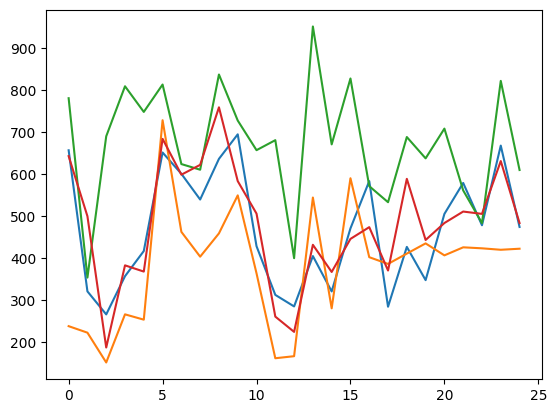

In [79]:
plt.plot(fid_score_content_stylized_dfr)
plt.plot(fid_score_content_stylized_art)
plt.plot(fid_score_content_stylized_fst)
plt.plot(fid_score_content_stylized_nst)
plt.show()

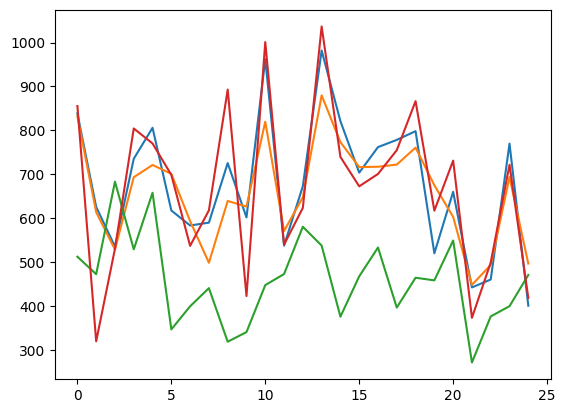

In [80]:
plt.plot(fid_score_style_stylized_dfr)
plt.plot(fid_score_style_stylized_art)
plt.plot(fid_score_style_stylized_fst)
plt.plot(fid_score_style_stylized_nst)
plt.show()